# Γιάννης Δαλιάνης 1115201700027

Imports.

In [1]:
import csv
import pandas as pd
import re
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

from textblob import TextBlob

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn import naive_bayes
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords, words
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents, WordPunctTokenizer

import warnings
warnings.filterwarnings('ignore')

Read csv files and remove Usage and Date columns.

In [2]:
VerificationLabels = pd.read_csv('./data/impermium_verification_labels.csv')
VerificationSet = pd.read_csv('./data/impermium_verification_set.csv')
train = pd.read_csv('./data/train.csv')

VerificationLabels = VerificationLabels.drop(columns='Usage')
VerificationLabels = VerificationLabels.drop(columns='Date')
VerificationSet = VerificationSet.drop(columns='Usage')
VerificationSet = VerificationSet.drop(columns='Date')
train = train.drop(columns='Date')

Lower all characters, convert insult labels to int and remove empty rows.

In [3]:
VerificationLabels = VerificationLabels.apply(lambda x: x.astype(str).str.lower())
VerificationSet = VerificationSet.apply(lambda x: x.astype(str).str.lower())
train = train.apply(lambda x: x.astype(str).str.lower())

VerificationLabels['Insult'] = VerificationLabels['Insult'].astype(int)
train['Insult'] = train['Insult'].astype(int)

Clean Comment Columns and remove empty Comment Rows.

In [4]:
def cleanText(text):
    # remove hashtags and mentions
    text = text.str.replace(r'#.*?(?=\s|$)', '')
    text = text.str.replace(r'@.*?(?=\s|$)', '')

    # remove urls
    text = text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    text = text.apply(lambda x: re.split('https:\/\/.*', str(x))[0])

    # remove newlines and other special characters
    text = text.replace(r'\\n',' ', regex=True)
    text = text.replace(r'\\u',' ', regex=True)
    text = text.replace(r'\\x',' ', regex=True)

    # remove all numbers
    text = text.str.replace('\d+', '')

    # remove words with 2 or 1 letter only
    text = text.str.replace(r'\b(\w{1,2})\b', '')

    # remove punctuations
    text = text.str.replace('[^\w\s]','')

    # replace multiple whitespaces
    text = text.apply(lambda x: re.sub(' +', ' ', x))

#     # remove non english words
#     words = set(words.words())
#     text = text.apply(lambda x: ' '.join([w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()]))
 
    return text

train['Comment'] = cleanText(train['Comment'])
VerificationLabels['Comment'] = cleanText(VerificationLabels['Comment'])
VerificationSet['Comment'] = cleanText(VerificationSet['Comment'])

nan_value = float("NaN")
train['Comment'].replace("", nan_value, inplace=True)
VerificationSet['Comment'].replace("", nan_value, inplace=True)
VerificationLabels['Comment'].replace("", nan_value, inplace=True)

train.dropna(subset=['Comment'], inplace=True)
VerificationSet.dropna(subset=['Comment'], inplace=True)
VerificationLabels.dropna(subset=['Comment'], inplace=True)

# train.to_csv('./madeNew/trainCleaned.tsv', sep='\t', index=False)
# VerificationLabels.to_csv('./madeNew/VerificationLabelsCleaned.tsv', sep='\t', index=False)
# VerificationSet.to_csv('./madeNew/VerificationSetCleaned.tsv', sep='\t', index=False)

Function that separates Train and Test Data and Encodes Labels.

In [5]:
def MakeSets(trainText, trainLabels, testText, testLabels):
    Train_X = trainText
    Train_Y = trainLabels
    
    Test_X = testText
    Test_Y = testLabels
    
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)
    
    return Train_X, Train_Y, Test_X, Test_Y

Train_X, Train_Y, Test_X, Test_Y = MakeSets(train['Comment'], train['Insult'], VerificationSet['Comment'], VerificationLabels['Insult'])

Count vectorizer for Naive Bayes.

In [6]:
train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(1, 1))
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

## Naive Bayes with and without Laplace Smoothing, SVM and RDF functions.

In [7]:
def NaiveFun(trainX , trainY, testX, testY):
    Naive = naive_bayes.GaussianNB()
    Naive.fit(trainX.toarray(), trainY)
    predictions_NB = Naive.predict(testX.toarray())

    print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, testY)*100)
    print("Naive Bayes F1-Score -> ",f1_score(predictions_NB, testY, average='macro')*100)
    
def NaiveFunLaplaceSmoothing(trainX , trainY, testX, testY):
    Naive = naive_bayes.MultinomialNB(alpha = 1.0000000000000001e-10)
    
    Naive.fit(trainX, trainY)
    predictions_NB = Naive.predict(testX)

    print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, testY)*100)
    print("Naive Bayes F1-Score -> ",f1_score(predictions_NB, testY, average='macro')*100)

def SVMex(trainX, trainY, testX, testY):
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma=0.1, probability=True)
    SVM.fit(trainX, trainY)
    predictions_SVM = SVM.predict(testX)
    
    print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, testY)*100)
    print("SVM F1-Score -> ",f1_score(predictions_SVM, testY, average='macro')*100)

def RandomF(trainX, trainY, testX, testY, Test_Y_Random_Forests):
    rf = RandomForestClassifier(n_estimators=50, bootstrap = True, max_features = 'sqrt')
    rf.fit(trainX, trainY)
    predictions = rf.predict(testX)

    print("RDF Accuracy Score -> ",accuracy_score(predictions, testY)*100)
    print("RDF F1-Score -> ",f1_score(predictions, testY, average='macro')*100)
    
    fig = plt.figure(figsize=[15,10])
    # Plot the actual values
    plt.plot(testY[:100], 'b-', label = 'actual')
    # Plot the predicted values
    plt.plot(predictions[:100], 'ro', label = 'prediction')
    plt.xticks(rotation = '60'); 
    plt.legend()
    plt.title('Actual and Predicted Values on a sample of 100 Strings.');

## Naive Bayes.

In [8]:
NaiveFun(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  51.991051454138706
Naive Bayes F1-Score ->  51.99009033807963


Χαμηλό σκορ επειδή οι περισσότερες προσβολές στην καθημερινή ζωή δεν είναι μόνο μία λέξη από μόνη της, οπότε εφόσον δε δίνουμε σα παράμετρο να υπολογιστούν οι λέξεις σε ζεύγη που εμφανίζονται, πολλά προσβλητικά περιεχόμενα δεν αξιολογούνται σωστά. Επίσης κάποια train δεδομένα δεν είναι σωστά αξιολογημένα όπως έχουν δοθεί.

## Optimize Naive Bayes.

Lemmatization.

In [9]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

tmpTrain = train
tmpTrain['Lemmatization'] = tmpTrain.Comment.apply(lemmatize_text)
tmpTrain['Lemmatization'] = tmpTrain['Lemmatization'].apply(lambda x: ' '.join(x))

tmpVerification = VerificationLabels
tmpVerification['Lemmatization'] = tmpVerification.Comment.apply(lemmatize_text)
tmpVerification['Lemmatization'] = tmpVerification['Lemmatization'].apply(lambda x: ' '.join(x))

Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['Lemmatization'], tmpTrain['Insult'], tmpVerification['Lemmatization'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(1, 1))
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

NaiveFun(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  50.82774049217002
Naive Bayes F1-Score ->  50.740606077865166


Το σκορ είναι ελάχιστα χειρότερο από πριν καθώς οι αλλαγές που πραγματοποιούνται στις λέξεις είναι πολύ μικρές και δε κάνουν διαφορά στο classification, ίσα ίσα επιδεινώνουν το αποτέλεσμα.

Remove stop words.

In [10]:
stop = stopwords.words('english')
tmpTrain['RemStopWords'] = tmpTrain.Comment.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tmpVerification['RemStopWords'] = tmpVerification.Comment.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['RemStopWords'], tmpTrain['Insult'], tmpVerification['RemStopWords'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(1, 1))
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

NaiveFun(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  51.72259507829977
Naive Bayes F1-Score ->  51.72244044243194


Τα stopwords φαίνεται ότι είχαν πού μικρό αντίκτυπο στο σκορ και η αφαίρεσή τους δεν έκανε σχεδόν καμία διαφορά.

Use bigrams.

In [11]:
Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['Comment'], tmpTrain['Insult'], tmpVerification['Comment'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(2, 2))
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

NaiveFun(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  55.57046979865772
Naive Bayes F1-Score ->  55.56691175366504


Βελτιώνεται το σκορ καθώς ταξινομούμε τις λέξεις σε ζεύγη και έτσι καταγράφουμε με καλύτερη απόδοση κάποιες συχνές προσβλητικές εκφράσεις.

Use Laplace Smoothing.

In [12]:
Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['Comment'], tmpTrain['Insult'], tmpVerification['Comment'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer()
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

NaiveFunLaplaceSmoothing(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  58.70246085011186
Naive Bayes F1-Score ->  58.20431554743421


Με τη μέθοδο Laplace Smoothing αντιμετωπίζουμε το zero probability problem, δηλαδή την ύπαρξη μηδενικών πιθανοτήτων. Για παράδειγμα μπορεί μια συγκεκριμένη λέξη στο train set μας να συναντιέται μόνο σε προσβλητικές προτάσεις. Αυτό όμως δε σημαίνει ότι όποια πρόταση την περιέχει είναι εξ' ορισμού προσβλητική.

All technics together.

In [13]:
tmpTrain['AllTog'] = tmpTrain.Comment.apply(lemmatize_text)
tmpTrain['AllTog'] = tmpTrain['AllTog'].apply(lambda x: ' '.join(x))

tmpVerification['AllTog'] = tmpVerification.Comment.apply(lemmatize_text)
tmpVerification['AllTog'] = tmpVerification['AllTog'].apply(lambda x: ' '.join(x))

stop = stopwords.words('english')
tmpTrain['AllTog'] = tmpTrain.AllTog.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tmpVerification['AllTog'] = tmpVerification.AllTog.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['AllTog'], tmpTrain['Insult'], tmpVerification['AllTog'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(2, 2))
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

NaiveFunLaplaceSmoothing(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  58.61297539149888
Naive Bayes F1-Score ->  53.57894829022107


## Optimize Naive Bayes with uni-bi-trigrams and Stemming.

In [14]:
tmpTrain['Opt'] = tmpTrain.Comment.apply(lemmatize_text)
tmpTrain['Opt'] = tmpTrain['Opt'].apply(lambda x: ' '.join(x))

tmpVerification['Opt'] = tmpVerification.Comment.apply(lemmatize_text)
tmpVerification['Opt'] = tmpVerification['Opt'].apply(lambda x: ' '.join(x))

stop = stopwords.words('english')
tmpTrain['Opt'] = tmpTrain.Opt.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tmpVerification['Opt'] = tmpVerification.Opt.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stemmer = SnowballStemmer("english")
tmpTrain['Opt'] = tmpTrain['Opt'].apply(lambda x: [stemmer.stem(y) for y in nltk.word_tokenize(x)])
tmpTrain['Opt'] = tmpTrain['Opt'].apply(lambda x: ' '.join(x))
tmpVerification['Opt'] = tmpVerification['Opt'].apply(lambda x: [stemmer.stem(y) for y in nltk.word_tokenize(x)])
tmpVerification['Opt'] = tmpVerification['Opt'].apply(lambda x: ' '.join(x))

# fixing spelling takes too much time
# tmpTrain['Opt'] = tmpTrain['Opt'].apply(lambda txt: ''.join(TextBlob(txt).correct()))
# tmpVerification['Opt'] = tmpVerification['Opt'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['Opt'], tmpTrain['Insult'], tmpVerification['Opt'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(1, 3))
bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

NaiveFunLaplaceSmoothing(bow_xtrain, Train_Y, bow_xtest, Test_Y)

Naive Bayes Accuracy Score ->  63.2662192393736
Naive Bayes F1-Score ->  61.626536221545905


Συνδυάζοντας όλα τα παραπάνω με Stemming και unigrams, bigrams, trigrams πετυχαίνουμε καλύτερο σκορ.

## Make POS tags and TFIDF columns.

In [15]:
tmpTrain['POSTags'] = pos_tag_sents(tmpTrain['Opt'].apply(word_tokenize).tolist()) # pos_tag
tmpVerification['POSTags'] = pos_tag_sents(tmpVerification['Opt'].apply(word_tokenize).tolist()) # pos_tag

Tfidf_vect = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 8000, stop_words = 'english')
Tfidf_vect.fit(tmpTrain['Opt'])

tmpTrain['TFIDF'] = list(Tfidf_vect.transform(tmpTrain['Opt']).toarray())

tmpVerification['TFIDF'] = list(Tfidf_vect.transform(tmpVerification['Opt']).toarray())

wpt = WordPunctTokenizer()
def PairWordsWithPOStags(text):
    textTok = wpt.tokenize(str(text))
    text_tagged = pos_tag(textTok)
    new_text = []
    for word in text_tagged:
        new_text.append(word[0] + "_" + word[1])
    doc = ' '.join(new_text)
    return doc

def POStagsOnly(text):
    textTok = wpt.tokenize(str(text))
    text_tagged = pos_tag(textTok)
    new_text = []
    for word in text_tagged:
        new_text.append(word[1])
    doc = ' '.join(new_text)
    return doc

tmpTrain["Paired"] = tmpTrain['Opt'].apply(PairWordsWithPOStags)
tmpVerification["Paired"] = tmpVerification['Opt'].apply(PairWordsWithPOStags)

tmpTrain["TagsOnly"] = tmpTrain['Opt'].apply(POStagsOnly)
tmpVerification["TagsOnly"] = tmpVerification['Opt'].apply(POStagsOnly)

tmpTrain.head()

,Insult,Comment,Lemmatization,RemStopWords,AllTog,Opt,POSTags,TFIDF,Paired,TagsOnly
0,1,you fuck your dad,you fuck your dad,fuck dad,fuck dad,fuck dad,"[(fuck, NN), (dad, NN)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fuck_NN dad_NN,NN NN
1,0,really don understand your point seems that y...,really don understand your point seem that you...,really understand point seems mixing apples or...,really understand point seem mix apples oranges,realli understand point seem mix appl orang,"[(realli, NN), (understand, NN), (point, NN), ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",realli_NN understand_NN point_NN seem_VBP mix_...,NN NN NN VBP JJ NN NN
2,0,amajority canadians can and has been wrong be...,amajority canadians can and have be wrong befo...,amajority canadians wrong unless supportive id...,amajority canadians wrong unless supportive id...,amajor canadian wrong unless support idea noth...,"[(amajor, JJ), (canadian, JJ), (wrong, JJ), (u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",amajor_JJ canadian_JJ wrong_JJ unless_IN suppo...,JJ JJ JJ IN NN NN CC JJ NN JJ VB NN NN NNP NN ...
3,0,listen you dont wanna get married man women do...,listen you dont wanna get marry man women dont...,listen dont wanna get married man women dont w...,listen dont wanna get marry man women dont wou...,listen dont wan na get marri man women dont wo...,"[(listen, JJ), (dont, NN), (wan, NN), (na, TO)...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",listen_JJ dont_NN wan_NN na_TO get_VB marri_JJ...,JJ NN NN TO VB JJ NN NNS RB MD VB NN NN VBP JJ...
4,0,ean edng eddng ecu ecnh fng edi eau chi eec f...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,"[(ean, JJ), (edng, NN), (eddng, NN), (ecu, NN)...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ean_JJ edng_NN eddng_NN ecu_NN ecnh_NN fng_NN ...,JJ NN NN NN NN NN NN NN NN FW NN NN NN NN NN N...


Φτιάχνουμε τη στήλη με το TFIDF σκορ, μια στήλη με τα POS tags, την στήλη Paired που κάνει concat κάθε λέξη με το Tag της και τη στήλη TagsOnly που περιέχει σα strings μόνο τα Tags της κάθε πρότασης.

Πρώτα εκτελούμε SVM και RDF μόνο στα TFIDF scores και στα Paired σχόλια.

SVM on POS-Paired comments.

In [16]:
Train_X, Train_Y, Test_X, Test_Y = MakeSets(tmpTrain['Paired'], tmpTrain['Insult'], tmpVerification['Paired'], tmpVerification['Insult'])

train_to_list = np.array(Train_X.values.tolist())

BoWvect = CountVectorizer(ngram_range=(1, 3))

bow_xtrain = BoWvect.fit_transform(train_to_list)
bow_xtest = BoWvect.transform(Test_X)

Test_Y_Random_Forests = tmpVerification['Insult']
SVMex(bow_xtrain, Train_Y, bow_xtest, Test_Y)

SVM Accuracy Score ->  67.91946308724832
SVM F1-Score ->  65.1884964620323


SVM on TFIDF.

In [17]:
Train_X_Tfidf = tmpTrain['TFIDF'].tolist()
Test_X_Tfidf = tmpVerification['TFIDF'].tolist()

SVMex(Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y)

SVM Accuracy Score ->  68.50111856823267
SVM F1-Score ->  65.73519163763066


RDF on POS-Paired comments.

RDF Accuracy Score ->  64.7427293064877
RDF F1-Score ->  60.69791231509153


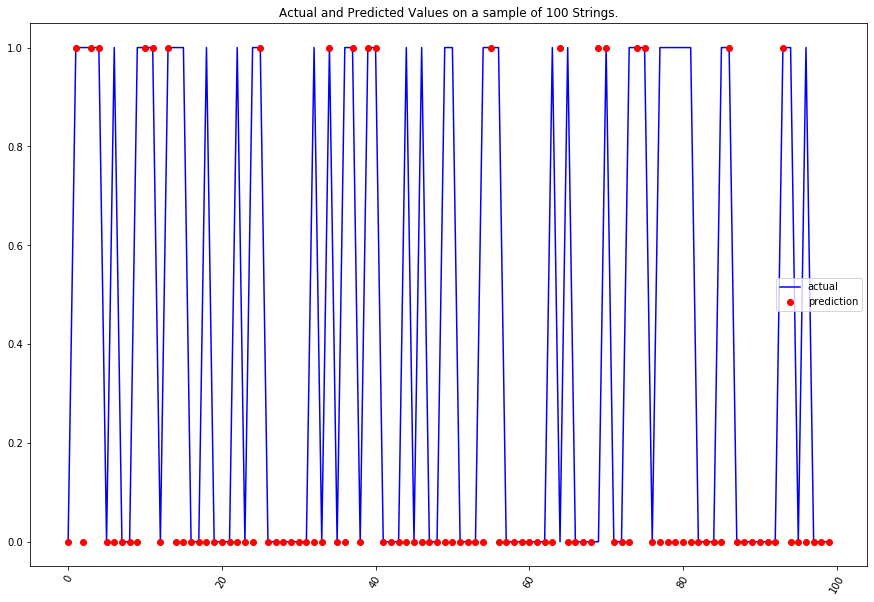

In [18]:
RandomF(bow_xtrain, Train_Y, bow_xtest, Test_Y, Test_Y_Random_Forests)

RDF on TFIDF.

RDF Accuracy Score ->  66.48769574944072
RDF F1-Score ->  63.80947089444935


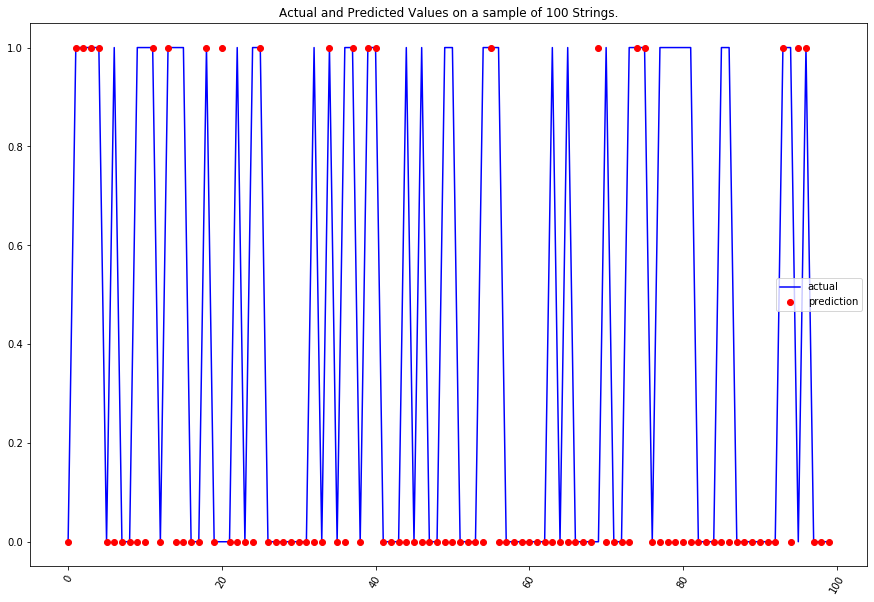

In [19]:
Train_X_Tfidf = tmpTrain['TFIDF'].tolist()
Test_X_Tfidf = tmpVerification['TFIDF'].tolist()

RandomF(Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y, Test_Y_Random_Forests)

## Find POS tags and fractions.

In [20]:
def POSTagger(text):
    lower_case = text.lower()
    tokens = word_tokenize(lower_case)
    tags = pos_tag(tokens)
    counts = Counter( tag for word, tag in tags)
    return counts

def POSTaggerAdverbs(text):
    CountAdverbs=0
    Total=0
    lower_case = text.lower()
    tokens = word_tokenize(lower_case)
    tags = pos_tag(tokens)
    counts = Counter( tag for word, tag in tags)
    for i, j in counts.items():
        Total+=j
        if(i=='RB' or i=='RBR' or i=='RBS'):
            CountAdverbs+=j
    if(Total!=0):
        return ((CountAdverbs*100) / Total)
    else:
        return 0

def POSTaggerNouns(text):
    CountrNouns=0
    Total=0
    lower_case = text.lower()
    tokens = word_tokenize(lower_case)
    tags = pos_tag(tokens)
    counts = Counter( tag for word, tag in tags)
    for i, j in counts.items():
        Total+=j
        if(i=='NN' or i=='NNS' or i=='NNP' or i=='NNPS'):
            CountrNouns+=j
    if(Total!=0):
        return ((CountrNouns*100) / Total)
    else:
        return 0

def POSTaggerVerbs(text):
    CountVerbs=0.0
    Total=0
    lower_case = text.lower()
    tokens = word_tokenize(lower_case)
    tags = pos_tag(tokens)
    counts = Counter( tag for word, tag in tags)
    for i, j in counts.items():
        Total+=j
        if(i=='VB' or i=='VBD' or i=='VBG' or i=='VBN' or i=='VBP' or i=='VBZ'):
            CountVerbs+=j
    if(Total!=0):
        return ((CountVerbs*100) / Total)
    else:
        return 0

def POSTaggerAdjectives(text):
    CountAdjectives=0
    Total=0
    lower_case = text.lower()
    tokens = word_tokenize(lower_case)
    tags = pos_tag(tokens)
    counts = Counter( tag for word, tag in tags)
    for i, j in counts.items():
        Total+=j
        if(i=='JJ' or i=='JJR' or i=='JJS'):
            CountAdjectives+=j
    if(Total!=0):
        return ((CountAdjectives*100) / Total)
    else:
        return 0
    
tmpTrain["POSTagger"] = tmpTrain['Opt'].apply(POSTagger)
tmpTrain['fractionAdverbs'] = tmpTrain['Opt'].apply(POSTaggerAdverbs)
tmpTrain['fractionVerbs'] = tmpTrain['Opt'].apply(POSTaggerVerbs)
tmpTrain['fractionAdjectives'] = tmpTrain['Opt'].apply(POSTaggerAdjectives)
tmpTrain['fractionNouns'] = tmpTrain['Opt'].apply(POSTaggerNouns)

tmpVerification["POSTagger"] = tmpVerification['Opt'].apply(POSTagger)
tmpVerification['fractionAdverbs'] = tmpVerification['Opt'].apply(POSTaggerAdverbs)
tmpVerification['fractionVerbs'] = tmpVerification['Opt'].apply(POSTaggerVerbs)
tmpVerification['fractionAdjectives'] = tmpVerification['Opt'].apply(POSTaggerAdjectives)
tmpVerification['fractionNouns'] = tmpVerification['Opt'].apply(POSTaggerNouns)

tmpTrain.head()

,Insult,Comment,Lemmatization,RemStopWords,AllTog,Opt,POSTags,TFIDF,Paired,TagsOnly,POSTagger,fractionAdverbs,fractionVerbs,fractionAdjectives,fractionNouns
0,1,you fuck your dad,you fuck your dad,fuck dad,fuck dad,fuck dad,"[(fuck, NN), (dad, NN)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fuck_NN dad_NN,NN NN,{'NN': 2},0.000000,0.000000,0.000000,100.000000
1,0,really don understand your point seems that y...,really don understand your point seem that you...,really understand point seems mixing apples or...,really understand point seem mix apples oranges,realli understand point seem mix appl orang,"[(realli, NN), (understand, NN), (point, NN), ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",realli_NN understand_NN point_NN seem_VBP mix_...,NN NN NN VBP JJ NN NN,"{'NN': 5, 'VBP': 1, 'JJ': 1}",0.000000,14.285714,14.285714,71.428571
2,0,amajority canadians can and has been wrong be...,amajority canadians can and have be wrong befo...,amajority canadians wrong unless supportive id...,amajority canadians wrong unless supportive id...,amajor canadian wrong unless support idea noth...,"[(amajor, JJ), (canadian, JJ), (wrong, JJ), (u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",amajor_JJ canadian_JJ wrong_JJ unless_IN suppo...,JJ JJ JJ IN NN NN CC JJ NN JJ VB NN NN NNP NN ...,"{'JJ': 6, 'IN': 2, 'NN': 15, 'CC': 1, 'VB': 2,...",0.000000,7.407407,22.222222,59.259259
3,0,listen you dont wanna get married man women do...,listen you dont wanna get marry man women dont...,listen dont wanna get married man women dont w...,listen dont wanna get marry man women dont wou...,listen dont wan na get marri man women dont wo...,"[(listen, JJ), (dont, NN), (wan, NN), (na, TO)...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",listen_JJ dont_NN wan_NN na_TO get_VB marri_JJ...,JJ NN NN TO VB JJ NN NNS RB MD VB NN NN VBP JJ...,"{'JJ': 7, 'NN': 11, 'TO': 1, 'VB': 3, 'NNS': 1...",3.571429,17.857143,25.000000,42.857143
4,0,ean edng eddng ecu ecnh fng edi eau chi eec f...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,ean edng eddng ecu ecnh fng edi eau chi eec fn...,"[(ean, JJ), (edng, NN), (eddng, NN), (ecu, NN)...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ean_JJ edng_NN eddng_NN ecu_NN ecnh_NN fng_NN ...,JJ NN NN NN NN NN NN NN NN FW NN NN NN NN NN N...,"{'JJ': 2, 'NN': 38, 'FW': 2}",0.000000,0.000000,4.761905,90.476190


Η στήλη POSTagger περιέχει tuples με tags και το πλήθος εμφανίσεών τους σε κάθε σχόλιο και οι στήλες fraction περιέχουν το ποσοστό κάθε μίας εκ των 4 βασικών κατηγοριών tags σε κάθε σχόλιο.

## SVM and RDF on TFIDF and POS combined.

Combine Features.

Χρησιμοποιούμε 3 στήλες των δεδομένων μας για να τις συνδυάσουμε και να κάνουμε classify τα Test δεδομένα.

In [21]:
mapper = DataFrameMapper([
     ('Paired', CountVectorizer(ngram_range=(1, 3))),
     ('Opt', TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 8000, stop_words = 'english')),
     ('TagsOnly', CountVectorizer(ngram_range=(1, 3))),
#      ('TFIDF', None)
 ])

tmp_train = tmpTrain[['Opt', 'Paired', 'TFIDF', 'Insult', 'TagsOnly']]
tmp_test = tmpVerification[['Opt', 'Paired', 'TFIDF', 'Insult', 'TagsOnly']]

mapper.fit(tmp_train)
features = mapper.transform(tmp_train)
unknown = mapper.transform(tmp_test)

SVM.

In [22]:
SVMex(features, tmp_train['Insult'], unknown, tmp_test['Insult'])

SVM Accuracy Score ->  67.69574944071589
SVM F1-Score ->  65.2671233230534


RDF.

RDF Accuracy Score ->  61.61073825503356
RDF F1-Score ->  54.62407858221867


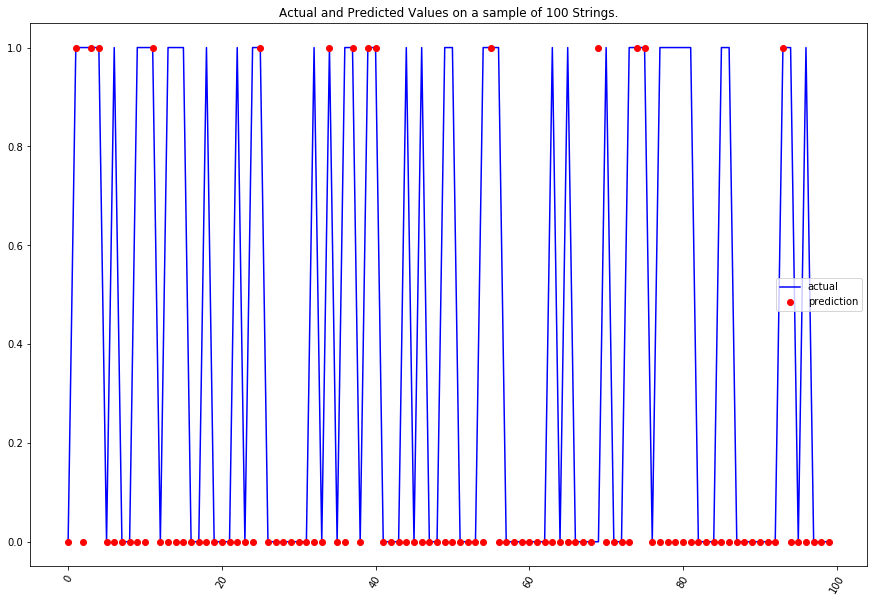

In [23]:
Test_Y_Random_Forests2 = tmp_test['Insult']
RandomF(features, tmp_train['Insult'], unknown, tmp_test['Insult'], Test_Y_Random_Forests2)